## Toinen neuroverkkokurssin menetelmätehtävä                                   Ville Kurikka

Aloitetaan lataamalla tarpeellisia importteja, ja lataamalla datasetti. Varataan 20 prosenttia riveistä lopulliseen testaamiseen.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, BatchNormalization, GaussianNoise
import tensorflow as tf
from keras.datasets import california_housing




(inputs, targets), (x_test, y_test) = california_housing.load_data(version='large', 
                                        test_split=0.2)





Jaetaan jäljelle jäänyt osuus training- ja validation dataseteiksi. 60 % kokonaismääräistä käytetään mallin opettamiseen, ja 20 % käytetään validointivaiheessa parametrien säätöön.

In [2]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(
    inputs, targets, test_size=0.25, random_state=42
)

print('Training shapes:', x_train.shape, y_train.shape)
print('Validation shapes:', x_val.shape, y_val.shape)


Training shapes: (12384, 8) (12384,)
Validation shapes: (4128, 8) (4128,)


Standardisoidaan data

In [3]:
mean = x_train.mean(axis=0)
std = x_train.std(axis=0)
x_train -= mean
x_train /= std
x_val -= mean
x_val /= std
x_test -= mean
x_test /= std

y_train /= 1e5
y_val /= 1e5
y_test /= 1e5

Aloitetaan mallin rakennus. Tehdään siis aluksi malli, joka selkeästi ylioppii

In [4]:

model = Sequential([
    Input(shape=(8,)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(x_train, y_train, epochs=200, batch_size=32, validation_data=(x_val, y_val), verbose=1)



Epoch 1/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 985us/step - loss: 0.8497 - mae: 0.6382 - val_loss: 0.4555 - val_mae: 0.4726
Epoch 2/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - loss: 0.3913 - mae: 0.4481 - val_loss: 0.4067 - val_mae: 0.4461
Epoch 3/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 0.3655 - mae: 0.4312 - val_loss: 0.3843 - val_mae: 0.4437
Epoch 4/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - loss: 0.3504 - mae: 0.4208 - val_loss: 0.3819 - val_mae: 0.4362
Epoch 5/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - loss: 0.3417 - mae: 0.4137 - val_loss: 0.3610 - val_mae: 0.4247
Epoch 6/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - loss: 0.3326 - mae: 0.4080 - val_loss: 0.3690 - val_mae: 0.4143
Epoch 7/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - loss: 0.3252 - mae: 0.3999 - val_loss: 0.3488 - val_mae: 0.4039
Epoch 8/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - loss: 0.3175 - mae: 0.3946 - val_loss: 0.3522 - val_mae: 0.4024
Epoch 9/200
387/387 ━━━━━━━━━━━━

Text(0, 0.5, 'Loss')

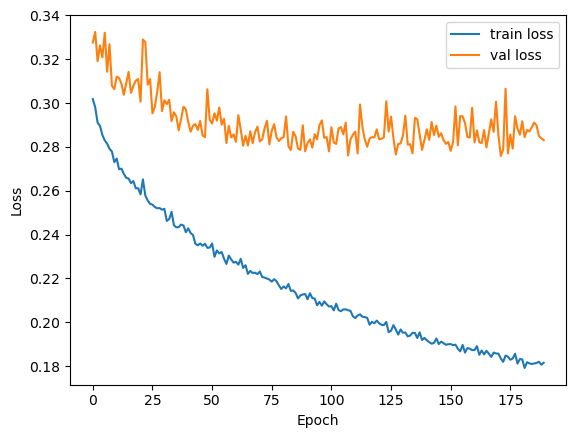

In [5]:

plt.plot(history.history['loss'][10:], label='train loss')
plt.plot(history.history['val_loss'][10:], label='val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')


Text(0, 0.5, 'Mean absolute error (in 100000 $)')

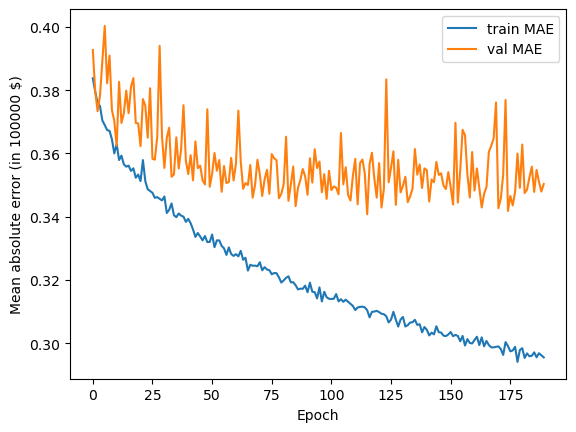

In [6]:
plt.plot(history.history['mae'][10:], label='train MAE')
plt.plot(history.history['val_mae'][10:], label='val MAE')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Mean absolute error (in 100000 $)')

Kuvaajien perusteella mallissa tapahtuu ylioppimista, sillä vaikka train loss ja train MAE laskevat tasaisesti, niin validation loss ja val MAE näyttävät pysyvän samoissa lukemissa tai jopa hieman kasvavan.

Työstetään nyt uusi malli, johon hyödynnetään erilaisia tekniikoita, joilla pyritään vähentämään ylioppimista.

Tarkastetaan vielä mallin tarkkuus. Eli mikä on MAE.

In [7]:
test_loss, test_mae = model.evaluate(x_test, y_test)
print(f'Test mean absolute error: {test_mae:.4f}')

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - loss: 0.2800 - mae: 0.3506
Test mean absolute error: 0.3506


Lisätään malliin batch normalization ja dropout-kerrokset. Näiden tulisi vähentää ylioppimista. Lisäksi lisätään malliin callbackit, jotka säätävät optimoijan learning ratea, ja lopettavat mallin opettamisen validation lossin laskun jäädessä jumiin. Varsinaisiin hidden-layereihin lisätään myös l2-regularisoijat.

In [8]:
model2 = Sequential([
    Input(shape=(8,)),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1)
])

model2.compile(optimizer='adam', loss='mse', metrics=['mae'])

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, min_lr=1e-5), # Vähennetään learning ratea maltillisesti, jotta ei aliopi.
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True) # Annetaan mallin pyöriä melko pitkään ennen lopetusta, koska muuten alioppii.
]

history2 = model2.fit(x_train, y_train, epochs=200, batch_size=32, validation_data=(x_val, y_val), verbose=1, callbacks=callbacks)

Epoch 1/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.1646 - mae: 1.0975 - val_loss: 0.5973 - val_mae: 0.5306 - learning_rate: 0.0010
Epoch 2/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - loss: 0.9411 - mae: 0.7030 - val_loss: 0.5063 - val_mae: 0.4510 - learning_rate: 0.0010
Epoch 3/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 0.7287 - mae: 0.6142 - val_loss: 0.4877 - val_mae: 0.4404 - learning_rate: 0.0010
Epoch 4/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 0.6354 - mae: 0.5628 - val_loss: 0.4605 - val_mae: 0.4295 - learning_rate: 0.0010
Epoch 5/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 0.5939 - mae: 0.5338 - val_loss: 0.4541 - val_mae: 0.4396 - learning_rate: 0.0010
Epoch 6/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 0.5594 - mae: 0.5201 - val_loss: 0.4440 - val_mae: 0.4284 - learning_rate: 0.0010
Epoch 7/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 0.5279 - mae: 0.5007 - val_loss: 0.4355 - val_mae: 0.4201 - learning_

Text(0, 0.5, 'Loss')

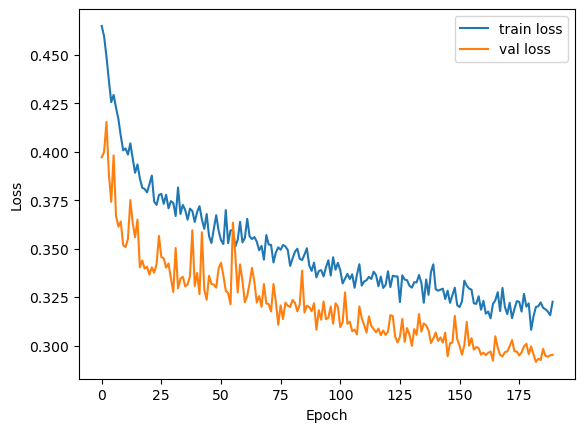

In [9]:
plt.plot(history2.history['loss'][10:], label='train loss')
plt.plot(history2.history['val_loss'][10:], label='val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Mean absolute error (in 100000 $)')

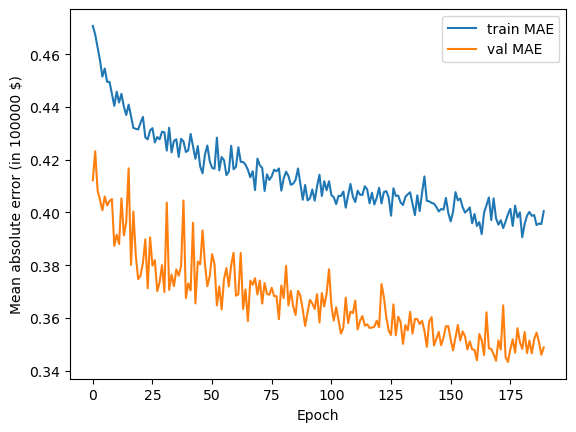

In [10]:
plt.plot(history2.history['mae'][10:], label='train MAE')
plt.plot(history2.history['val_mae'][10:], label='val MAE')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Mean absolute error (in 100000 $)')

Mielenkiintoisesti uuden mallin tarkkuus validointidatalla on parempi kuin opetusdatalla. Ylioppimista ei näytä tapahtuvan.

Opetetaan nyt sama malli niin, että yhdistetään opetus- ja validointidata suuremmaksi opetuskokonaisuudeksi, ja tarkastetaan sitten mallin MAE.

In [11]:
new_x_train = np.concatenate((x_train, x_val), axis=0)
new_y_train = np.concatenate((y_train, y_val), axis=0)

model3 = Sequential([
    Input(shape=(8,)),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1)
])

model3.compile(optimizer='adam', loss='mse', metrics=['mae'])

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, min_lr=1e-5), # Vähennetään learning ratea maltillisesti, jotta ei aliopi.
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True) # Annetaan mallin pyöriä melko pitkään ennen lopetusta, koska muuten alioppii.
]

history3 = model3.fit(new_x_train, new_y_train, epochs=200, batch_size=32, validation_data=(x_val, y_val), verbose=1, callbacks=callbacks)



Epoch 1/200
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.8626 - mae: 1.0036 - val_loss: 0.5345 - val_mae: 0.4591 - learning_rate: 0.0010
Epoch 2/200
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 0.8098 - mae: 0.6448 - val_loss: 0.5117 - val_mae: 0.4421 - learning_rate: 0.0010
Epoch 3/200
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - loss: 0.6637 - mae: 0.5688 - val_loss: 0.4762 - val_mae: 0.4438 - learning_rate: 0.0010
Epoch 4/200
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 946us/step - loss: 0.6012 - mae: 0.5357 - val_loss: 0.4439 - val_mae: 0.4168 - learning_rate: 0.0010
Epoch 5/200
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 946us/step - loss: 0.5582 - mae: 0.5139 - val_loss: 0.4419 - val_mae: 0.4120 - learning_rate: 0.0010
Epoch 6/200
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 946us/step - loss: 0.5304 - mae: 0.4979 - val_loss: 0.4266 - val_mae: 0.4277 - learning_rate: 0.0010
Epoch 7/200
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 951us/step - loss: 0.5080 - mae: 0.4869 - val_loss: 0.4175 - val_mae: 0.4112 - learning_

Text(0, 0.5, 'Loss')

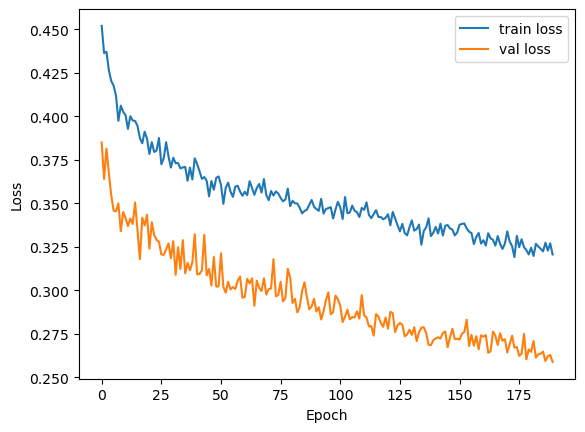

In [12]:
plt.plot(history3.history['loss'][10:], label='train loss')
plt.plot(history3.history['val_loss'][10:], label='val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Mean absolute error (in 100000 $)')

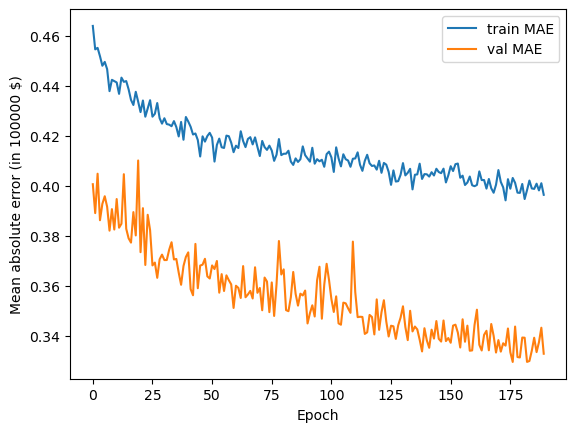

In [13]:
plt.plot(history3.history['mae'][10:], label='train MAE')
plt.plot(history3.history['val_mae'][10:], label='val MAE')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Mean absolute error (in 100000 $)')

In [14]:
test_loss, test_mae = model3.evaluate(x_test, y_test)
print(f'Test mean absolute error: {test_mae:.4f}')

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - loss: 0.2831 - mae: 0.3476
Test mean absolute error: 0.3476


Parannellun mallin MAE-luku on hieman parempi, mutta ei merkittävän. Ylioppiminen on kuitenkin selkeästi vähentynyt ensimmäiseen malliin verrattuna, joten uusi malli on kokonaisuutena parempi. Koska validation loss vaikuttaa edelleen laskevan yhdistetyllä datalla treenatussa mallissa, mahdollisesti pelkkä epookkien lisääminen saattaisi parantaa mallin tarkkuutta.